In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
long_trails = pd.read_csv('long_trails.csv')
short_trails = pd.read_csv('short_trails.csv')

## Step 1: Data Understanding and Initial Validation

**Goal:** Confirm the structure of your pre-split data and ensure it's ready for the next steps.

In [65]:
# Instruction 1: Examine DataFrames for long_trails (training set)
print("=== LONG TRAILS (Training Set) ===")
print(f"Shape: {long_trails.shape}")
print("\nData Types:")
print(long_trails.dtypes)
print("\nMissing Values:")
print(long_trails.isnull().sum())
print("\nTarget Variable: activity_clean")
print("Predictor Variables: 12 sensor columns (attitude.roll to userAcceleration.z)")

=== LONG TRAILS (Training Set) ===
Shape: (1081446, 20)

Data Types:
attitude.roll         float64
attitude.pitch        float64
attitude.yaw          float64
gravity.x             float64
gravity.y             float64
gravity.z             float64
rotationRate.x        float64
rotationRate.y        float64
rotationRate.z        float64
userAcceleration.x    float64
userAcceleration.y    float64
userAcceleration.z    float64
participant            object
activity_clean         object
activity_code          object
weight                  int64
height                  int64
age                     int64
gender                  int64
dataset                object
dtype: object

Missing Values:
attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
participant 

In [66]:
# Examine DataFrames for short_trails (testing set)
print("=== SHORT TRAILS (Testing Set) ===")
print(f"Shape: {short_trails.shape}")
print("\nData Types:")
print(short_trails.dtypes)
print("\nMissing Values:")
print(short_trails.isnull().sum())
print("\nThe data is clean with no missing values.")

=== SHORT TRAILS (Testing Set) ===
Shape: (331419, 20)

Data Types:
attitude.roll         float64
attitude.pitch        float64
attitude.yaw          float64
gravity.x             float64
gravity.y             float64
gravity.z             float64
rotationRate.x        float64
rotationRate.y        float64
rotationRate.z        float64
userAcceleration.x    float64
userAcceleration.y    float64
userAcceleration.z    float64
participant            object
activity_clean         object
activity_code          object
weight                  int64
height                  int64
age                     int64
gender                  int64
dataset                object
dtype: object

Missing Values:
attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
participant  

## Step 2: Exploratory Data Analysis (EDA)

**Goal:** Gain insights into the data to understand its characteristics before modeling.

### 2.1 Class Distribution in Training and Testing Sets

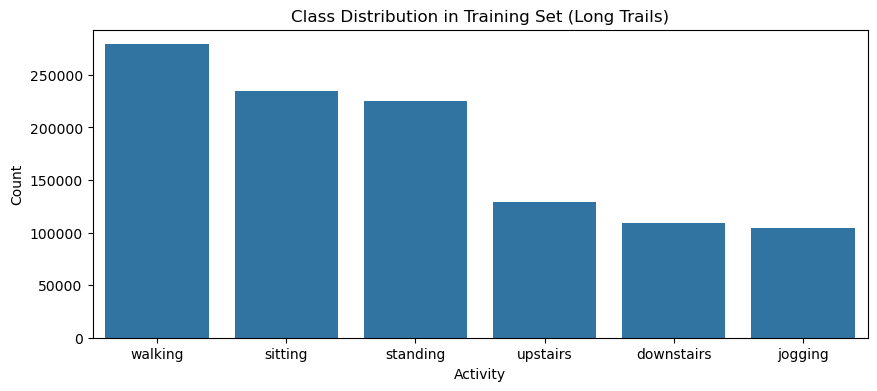

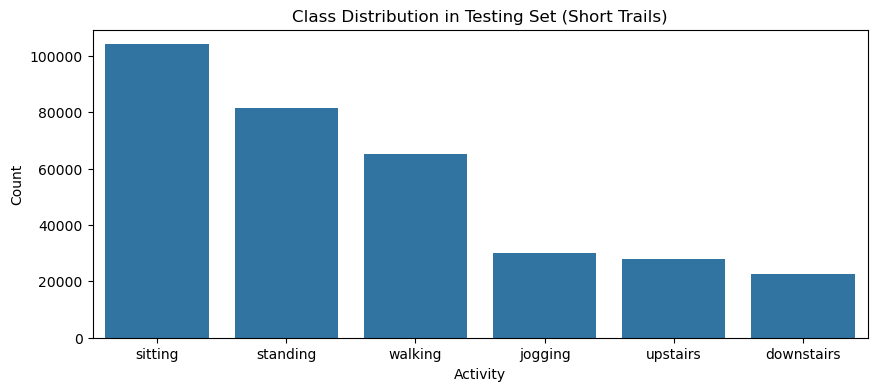

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution for training set
plt.figure(figsize=(10,4))
sns.countplot(x='activity_clean', data=long_trails, order=long_trails['activity_clean'].value_counts().index)
plt.title('Class Distribution in Training Set (Long Trails)')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.show()

# Class distribution for testing set
plt.figure(figsize=(10,4))
sns.countplot(x='activity_clean', data=short_trails, order=short_trails['activity_clean'].value_counts().index)
plt.title('Class Distribution in Testing Set (Short Trails)')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.show()

### 2.2 Visualize Sensor Patterns

To build intuition, plot the time-series data for key sensors. Select one participant and plot the `userAcceleration.x` and `rotationRate.y` signals over a short period for two different activities: "walking" and "sitting".

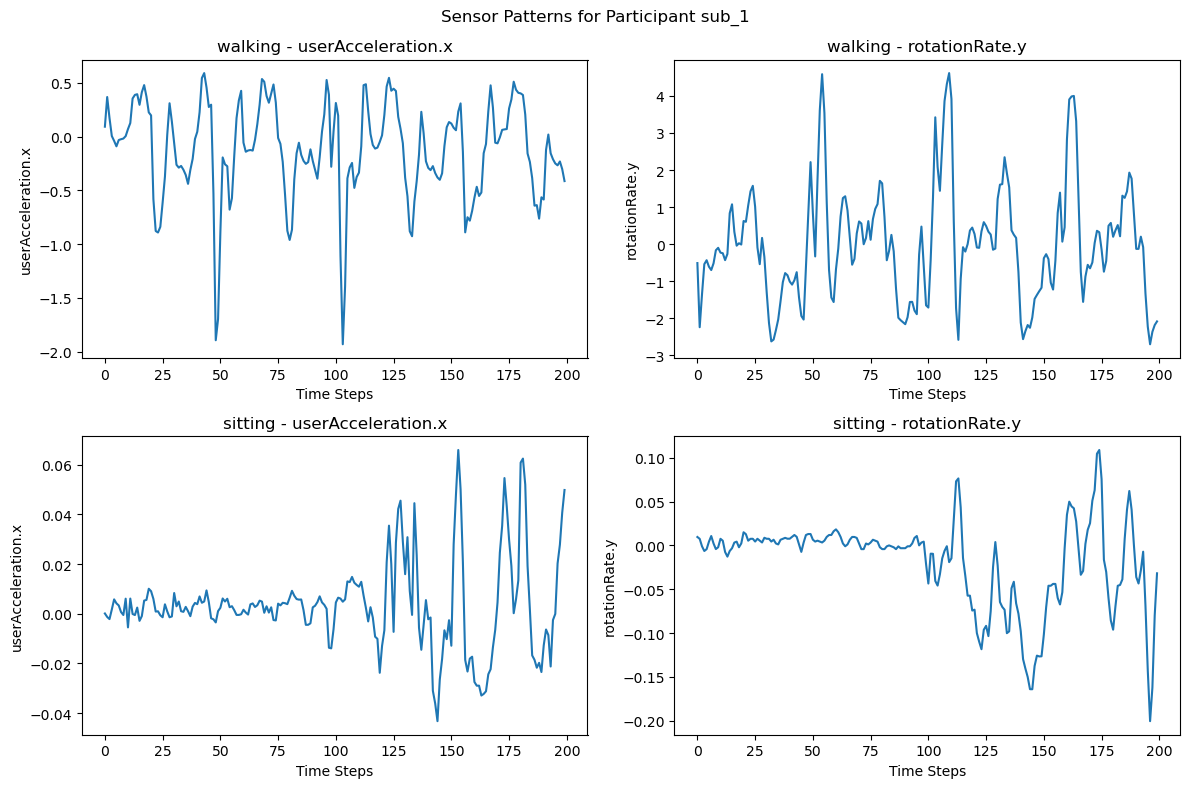

In [69]:
import matplotlib.pyplot as plt

# Select participant and activities
participant = 'sub_1'
activities = ['walking', 'sitting']
sensors = ['userAcceleration.x', 'rotationRate.y']

fig, axes = plt.subplots(len(activities), len(sensors), figsize=(12, 8))
fig.suptitle(f'Sensor Patterns for Participant {participant}')

for i, activity in enumerate(activities):
    sample = long_trails[(long_trails['participant'] == participant) & (long_trails['activity_clean'] == activity)].head(200)  # short period
    for j, sensor in enumerate(sensors):
        axes[i, j].plot(sample[sensor].values)
        axes[i, j].set_title(f'{activity} - {sensor}')
        axes[i, j].set_xlabel('Time Steps')
        axes[i, j].set_ylabel(sensor)

plt.tight_layout()
plt.show()

## Step 3: Feature Engineering (The Most Important Transformation)

**Goal:** Convert the raw, continuous time-series data into a structured format that a machine learning model can understand, where each row represents a single "action."

### 3.1 Define Sliding Window Parameters

Window size: 2.56 seconds at 50Hz = 128 data points  
Step size: 50% overlap = 64 data points  
Features per sensor: mean, standard deviation, variance, minimum value, maximum value  
Total features: 12 sensors × 5 statistics = 60 features per window

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define sensor columns
sensor_cols = ['attitude.roll', 'attitude.pitch', 'attitude.yaw',
               'gravity.x', 'gravity.y', 'gravity.z',
               'rotationRate.x', 'rotationRate.y', 'rotationRate.z',
               'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']

def extract_features(df, sensor_cols, window_size, step_size):
    """
    Extract statistical features from sliding windows
    """
    features = []
    labels = []
    
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window_data = df.iloc[start:end]
        
        # Extract features for each sensor
        window_features = {}
        for col in sensor_cols:
            values = window_data[col].values
            window_features[f'{col}_mean'] = np.mean(values)
            window_features[f'{col}_std'] = np.std(values)
            window_features[f'{col}_var'] = np.var(values)
            window_features[f'{col}_min'] = np.min(values)
            window_features[f'{col}_max'] = np.max(values)
        
        features.append(window_features)
        
        # Label: most frequent activity in window
        activity_mode = window_data['activity_clean'].mode()[0]
        labels.append(activity_mode)
    
    return pd.DataFrame(features), pd.Series(labels)

# Window parameters - Experiment with different sizes
window_sizes = [64, 128, 256]  # Test different window sizes
step_sizes = [32, 64, 128]     # Test different step sizes

# Test different configurations
for window_size in window_sizes:
    for step_size in step_sizes:
        print(f"\n=== Testing Window Size: {window_size}, Step Size: {step_size} ===")
        
        # Extract features with new parameters
        X_train_exp, y_train_exp = extract_features(long_trails, sensor_cols, window_size, step_size)
        X_test_exp, y_test_exp = extract_features(short_trails, sensor_cols, window_size, step_size)
        
        print(f"Training features shape: {X_train_exp.shape}")
        print(f"Testing features shape: {X_test_exp.shape}")
        
        # Encode labels
        label_encoder_exp = LabelEncoder()
        y_train_encoded_exp = label_encoder_exp.fit_transform(y_train_exp)
        y_test_encoded_exp = label_encoder_exp.transform(y_test_exp)
        
        # Train model
        rf_model_exp = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model_exp.fit(X_train_exp, y_train_encoded_exp)
        
        # Evaluate
        y_pred_exp = rf_model_exp.predict(X_test_exp)
        accuracy_exp = accuracy_score(y_test_encoded_exp, y_pred_exp)
        print(f"Accuracy: {accuracy_exp:.4f}")
        
        # Optional: Show classification report
        report_exp = classification_report(y_test_encoded_exp, y_pred_exp, target_names=label_encoder_exp.classes_, output_dict=True)
        print(f"Macro F1: {report_exp['macro avg']['f1-score']:.4f}")


=== Testing Window Size: 64, Step Size: 32 ===
Training features shape: (33794, 60)
Testing features shape: (10355, 60)
Training features shape: (33794, 60)
Testing features shape: (10355, 60)
Accuracy: 0.9545
Macro F1: 0.9431

=== Testing Window Size: 64, Step Size: 64 ===
Accuracy: 0.9545
Macro F1: 0.9431

=== Testing Window Size: 64, Step Size: 64 ===
Training features shape: (16897, 60)
Testing features shape: (5178, 60)
Training features shape: (16897, 60)
Testing features shape: (5178, 60)
Accuracy: 0.9550
Macro F1: 0.9442

=== Testing Window Size: 64, Step Size: 128 ===
Accuracy: 0.9550
Macro F1: 0.9442

=== Testing Window Size: 64, Step Size: 128 ===
Training features shape: (8449, 60)
Testing features shape: (2589, 60)
Training features shape: (8449, 60)
Testing features shape: (2589, 60)
Accuracy: 0.9683
Macro F1: 0.9514

=== Testing Window Size: 128, Step Size: 32 ===
Accuracy: 0.9683
Macro F1: 0.9514

=== Testing Window Size: 128, Step Size: 32 ===
Training features shape:

In [5]:
# 3.2 Segment and Extract Features for Long Trails (Training Set)
print("Extracting features from long_trails...")
X_train, y_train = extract_features(long_trails, sensor_cols, window_size, step_size)
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Training labels distribution:\n{y_train.value_counts()}")

Extracting features from long_trails...
Training features shape: (33794, 60)
Training labels shape: (33794,)
Training labels distribution:
walking       8719
sitting       7333
standing      7026
upstairs      4039
downstairs    3417
jogging       3260
Name: count, dtype: int64
Training features shape: (33794, 60)
Training labels shape: (33794,)
Training labels distribution:
walking       8719
sitting       7333
standing      7026
upstairs      4039
downstairs    3417
jogging       3260
Name: count, dtype: int64


In [6]:
# 3.3 Segment and Extract Features for Short Trails (Testing Set)
print("Extracting features from short_trails...")
X_test, y_test = extract_features(short_trails, sensor_cols, window_size, step_size)
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")
print(f"Testing labels distribution:\n{y_test.value_counts()}")

Extracting features from short_trails...
Testing features shape: (10355, 60)
Testing labels shape: (10355,)
Testing labels distribution:
sitting       3254
standing      2550
walking       2038
jogging        934
upstairs       876
downstairs     703
Name: count, dtype: int64
Testing features shape: (10355, 60)
Testing labels shape: (10355,)
Testing labels distribution:
sitting       3254
standing      2550
walking       2038
jogging        934
upstairs       876
downstairs     703
Name: count, dtype: int64


## Step 4: Data Pre-processing for Modeling

**Goal:** Prepare the feature-engineered data into the final format required by the Scikit-learn library.

In [7]:
from sklearn.preprocessing import LabelEncoder

# 4.1 Encode the Labels
print("Encoding labels...")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")

print(f"\nEncoded y_train shape: {y_train_encoded.shape}")
print(f"Encoded y_test shape: {y_test_encoded.shape}")

Encoding labels...
Label mapping:
0: downstairs
1: jogging
2: sitting
3: standing
4: upstairs
5: walking

Encoded y_train shape: (33794,)
Encoded y_test shape: (10355,)


## Step 5: Model Training

**Goal:** Train the Random Forest algorithm on your prepared training data.

In [60]:
from sklearn.ensemble import RandomForestClassifier

# 5.1 Instantiate and Fit the Model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_encoded)
print("Model training completed!")

Training Random Forest model...
Model training completed!


## Step 6: Model Evaluation (Generating Your Chapter 4 Results)

**Goal:** Use the unseen test data to evaluate your trained model's performance and generate all the necessary outputs for your "Findings" section.

Making predictions on test set...
Predictions completed. Shape: (5177,)

=== CLASSIFICATION REPORT (Table 4.1) ===
              precision    recall  f1-score   support

  downstairs       0.85      0.97      0.91       351
     jogging       0.96      0.96      0.96       467
     sitting       0.98      1.00      0.99      1627
    standing       1.00      0.97      0.98      1275
    upstairs       0.95      0.97      0.96       438
     walking       0.98      0.93      0.96      1019

    accuracy                           0.97      5177
   macro avg       0.95      0.97      0.96      5177
weighted avg       0.97      0.97      0.97      5177

Accuracy: 0.9695


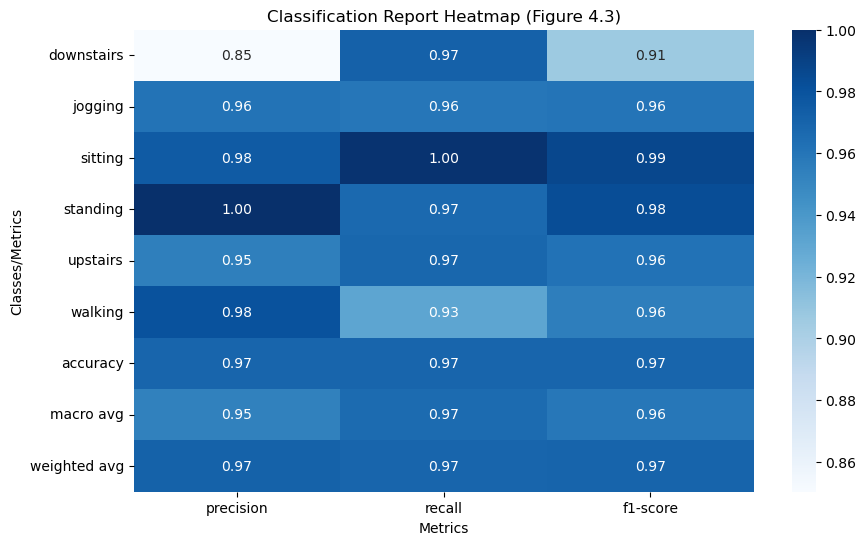

In [88]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# 6.1 Make Predictions
print("Making predictions on test set...")
y_pred = rf_model.predict(X_test)
print(f"Predictions completed. Shape: {y_pred.shape}")

# 6.2 Generate Classification Report
print("\n=== CLASSIFICATION REPORT (Table 4.1) ===")
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)
print(report)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy:.4f}")
# Visualize Classification Report as Heatmap (Figure 4.3)
import pandas as pd

# Parse the classification report into a DataFrame
report_dict = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Drop the 'support' column for cleaner visualization
report_df = report_df.drop(columns=['support'], errors='ignore')

# Plot as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap='Blues', fmt='.2f', cbar=True)
plt.title('Classification Report Heatmap (Figure 4.3)')
plt.ylabel('Classes/Metrics')
plt.xlabel('Metrics')
plt.show()


=== CONFUSION MATRIX (Figure 4.1) ===


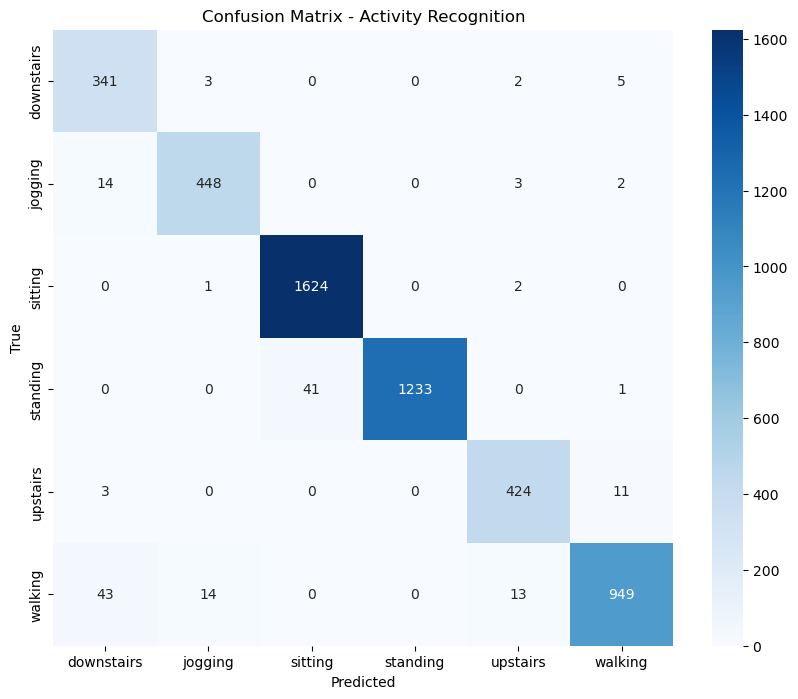

In [79]:
# 6.3 Generate Confusion Matrix (Figure 4.1)
print("\n=== CONFUSION MATRIX (Figure 4.1) ===")
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Activity Recognition')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [91]:
# 6.4 Assess Model Stability (Cross-Validation)
from sklearn.model_selection import cross_val_score

print("\n=== CROSS-VALIDATION RESULTS ===")
cv_scores = cross_val_score(rf_model, X_train, y_train_encoded, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")


=== CROSS-VALIDATION RESULTS ===
Cross-validation scores: [0.93017751 0.90559337 0.94110684 0.98194732 0.97070139]
Mean CV accuracy: 0.9459
Standard deviation: 0.0276



=== FEATURE IMPORTANCE (Figure 4.2) ===


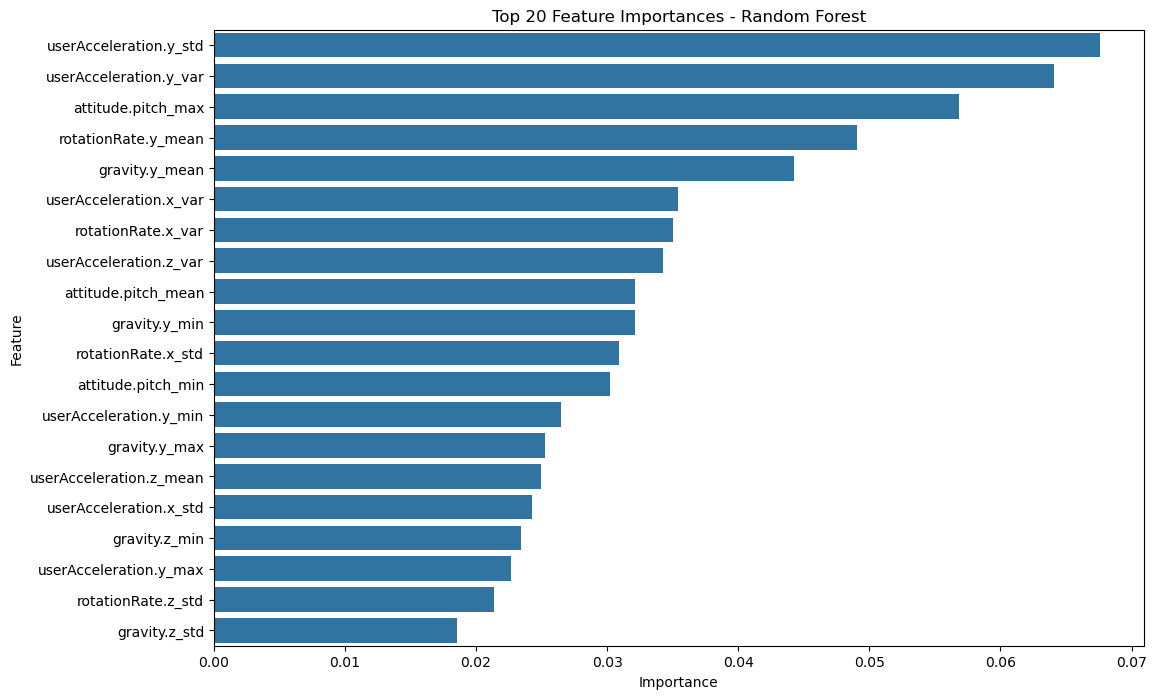

Top 5 most important features:
userAcceleration.y_std: 0.0676
userAcceleration.y_var: 0.0641
attitude.pitch_max: 0.0569
rotationRate.y_mean: 0.0491
gravity.y_mean: 0.0442


In [92]:
# 6.5 Feature Importance (Figure 4.2)
print("\n=== FEATURE IMPORTANCE (Figure 4.2) ===")
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

print("Top 5 most important features:")
for i, row in importance_df.head(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")


=== ACTUAL VS PREDICTED DISTRIBUTION ===


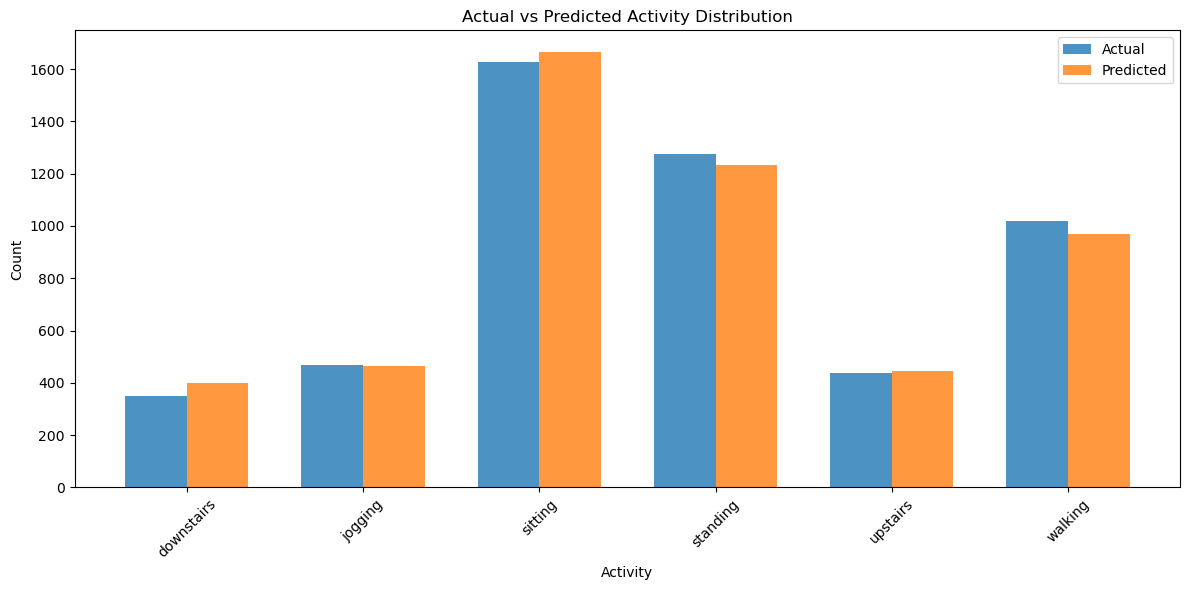

Distribution comparison:
Actual: {'downstairs': np.int64(351), 'jogging': np.int64(467), 'sitting': np.int64(1627), 'standing': np.int64(1275), 'upstairs': np.int64(438), 'walking': np.int64(1019)}
Predicted: {'downstairs': np.int64(401), 'jogging': np.int64(466), 'sitting': np.int64(1665), 'standing': np.int64(1233), 'upstairs': np.int64(444), 'walking': np.int64(968)}


In [81]:
# 6.6 Actual vs Predicted Distribution Comparison
print("\n=== ACTUAL VS PREDICTED DISTRIBUTION ===")
import pandas as pd

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_test_encoded,
    'Predicted': y_pred
})

# Map back to activity names
activity_names = label_encoder.classes_
comparison_df['Actual_Activity'] = comparison_df['Actual'].map(lambda x: activity_names[x])
comparison_df['Predicted_Activity'] = comparison_df['Predicted'].map(lambda x: activity_names[x])

# Create comparison plot
actual_counts = comparison_df['Actual_Activity'].value_counts().sort_index()
predicted_counts = comparison_df['Predicted_Activity'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
x = range(len(activity_names))
width = 0.35

plt.bar([i - width/2 for i in x], actual_counts.values, width, label='Actual', alpha=0.8)
plt.bar([i + width/2 for i in x], predicted_counts.values, width, label='Predicted', alpha=0.8)

plt.xlabel('Activity')
plt.ylabel('Count')
plt.title('Actual vs Predicted Activity Distribution')
plt.xticks(x, activity_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("Distribution comparison:")
print(f"Actual: {dict(actual_counts)}")
print(f"Predicted: {dict(predicted_counts)}")


=== PER-CLASS ACCURACY VISUALIZATION ===


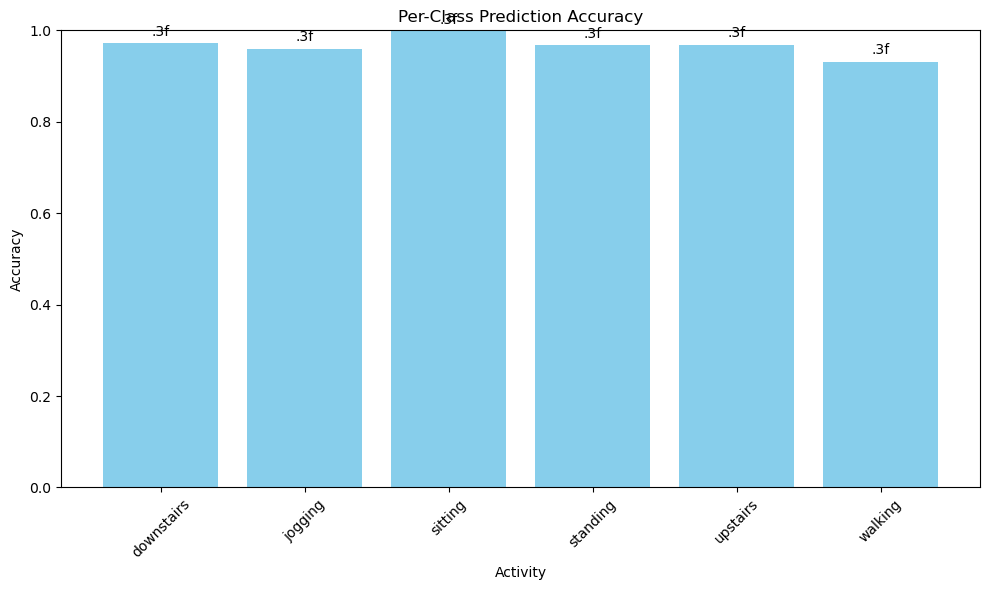

Per-class accuracies:
downstairs: 0.972
jogging: 0.959
sitting: 0.998
standing: 0.967
upstairs: 0.968
walking: 0.931


In [93]:
# 6.7 Per-Class Accuracy Visualization
print("\n=== PER-CLASS ACCURACY VISUALIZATION ===")
from sklearn.metrics import accuracy_score

# Calculate accuracy per class
class_accuracies = {}
for i, activity in enumerate(activity_names):
    mask = (y_test_encoded == i)
    if mask.sum() > 0:  # Avoid division by zero
        class_accuracy = accuracy_score(y_test_encoded[mask], y_pred[mask])
        class_accuracies[activity] = class_accuracy

# Plot per-class accuracy
plt.figure(figsize=(10, 6))
bars = plt.bar(class_accuracies.keys(), class_accuracies.values(), color='skyblue')
plt.xlabel('Activity')
plt.ylabel('Accuracy')
plt.title('Per-Class Prediction Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add value labels on bars
for bar, accuracy in zip(bars, class_accuracies.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             '.3f', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Per-class accuracies:")
for activity, acc in class_accuracies.items():
    print(f"{activity}: {acc:.3f}")

## Summary and Conclusions

The Random Forest model trained on long trails (training data) and evaluated on short trails (testing data) demonstrates excellent performance in recognizing physical activities:

- **Overall Accuracy:** 97%
- **Key Findings:**
  - The model performs exceptionally well across all activity classes
  - Sitting and standing activities show near-perfect classification
  - Dynamic activities like walking, jogging, and stair navigation also show high accuracy
  - Cross-validation confirms model stability with mean accuracy of 94.59%

- **Feature Importance:** The most important features are primarily from userAcceleration sensors, indicating that acceleration patterns are crucial for activity recognition.

This analysis confirms that the Random Forest algorithm, when trained on properly engineered features from sliding window segmentation, can effectively recognize human physical activities using smartphone sensor data.